In [9]:
import relaxation
import networkx as nx
import numpy as np

In this notebook we want to see:
- how different are different tree's local minimums;
- can we set up a relatively low local min? (from the tree template) 
- if k sum to desired value (constraint holds)

In [6]:
D_list = []
for i in range(10):
    G = relaxation.parameterize_leaf(6)
    relaxation.randomized_k(G)
    print(f'the {i+1} th graph')
    for j in range(30):
        relaxation.solve_P_theta(G)
        relaxation.new_k(G)
    print('dissipation D:', G.graph['D'])
    D_list.append(G.graph['D'])
    print('number of edges left:',G.number_of_edges())
    print()

the 1 th graph
dissipation D: 536227.9905991358
number of edges left: 36

the 2 th graph
dissipation D: 605025.9510418356
number of edges left: 36

the 3 th graph
dissipation D: 620174.6288501408
number of edges left: 36

the 4 th graph
dissipation D: 571600.2314234434
number of edges left: 36

the 5 th graph
dissipation D: 553674.2025694461
number of edges left: 36

the 6 th graph
dissipation D: 581903.1804927243
number of edges left: 36

the 7 th graph
dissipation D: 528737.9290480426
number of edges left: 36

the 8 th graph
dissipation D: 583306.3858048099
number of edges left: 36

the 9 th graph
dissipation D: 567847.1317054357
number of edges left: 36

the 10 th graph
dissipation D: 566722.1413254242
number of edges left: 36



In [7]:
D_list

[536227.9905991358,
 605025.9510418356,
 620174.6288501408,
 571600.2314234434,
 553674.2025694461,
 581903.1804927243,
 528737.9290480426,
 583306.3858048099,
 567847.1317054357,
 566722.1413254242]

There are quite big changes in the local mins from different starts.

In [30]:
def parametrize_tree(N,gamma, hydathode = 'None', strength = 5):

    """ 
    Parametrize a triangular graph of size N with normalization by cost parameter gamma, 
    such that all edges that do not belong to the symmetric tree shown in Fig.2c 
    start with zero capacity and all other capacities are normalized such that
    \sum_{e}k_e^\gamma = 1

    incorporate ideas for hydathodes
    """
    
    G = nx.generators.triangular_lattice_graph(N,2*N)
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)
            
    es = [((i,int(N/2)),(i+1,int(N/2))) for i in range(N)]
    
    for i in range(len(es)):
        es2_path = [(i+int((j+1)/2),int(N/2)+j) for j in range(int(N/2)+1)]
        es2 = list(zip(es2_path,es2_path[1:]))
        es3_path = [(i+int((j+1)/2),int(N/2)-j) for j in range(int(N/2)+1)]
        es3 = list(zip(es3_path,es3_path[1:]))
        es += es2
        es += es3
        
    caps = {}
    for u,v in G.edges():
        if (u,v) in es or (u,v)[::-1] in es:
            caps[(u,v)] = 1.0/len(es)**(1/gamma)
        else:
            caps[(u,v)] = 0.0
    nx.set_edge_attributes(G,caps,'weight')
    nx.set_edge_attributes(G, 0, 'F') # let's assume that flow is always a positive number here
    nx.set_node_attributes(G, 0, 'theta')

    if hydathode == 'None':

        # add edge attr:
        nx.set_node_attributes(G, -1, 'P') # set node strength
        G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # set supply node strength
        # initialize potentials, not important, will be the first thing to calculate
        nx.set_node_attributes(G, 'C0', 'color')

    else: 
        # add edge attr, renormalize sinks: 
        re_norm = (G.number_of_nodes() - 1)/(G.number_of_nodes() - 2 + strength) 
        nx.set_node_attributes(G, -1*re_norm, 'P') # set node strength
        G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # keep supply consistent
        G.nodes[hydathode]['P'] = -strength*re_norm
        
        nx.set_node_attributes(G, 'C0', 'color')
        G.nodes[hydathode]['color'] = 'C1'
   

    return G

In [31]:
G = parametrize_tree(N= 6,gamma = 0.5)

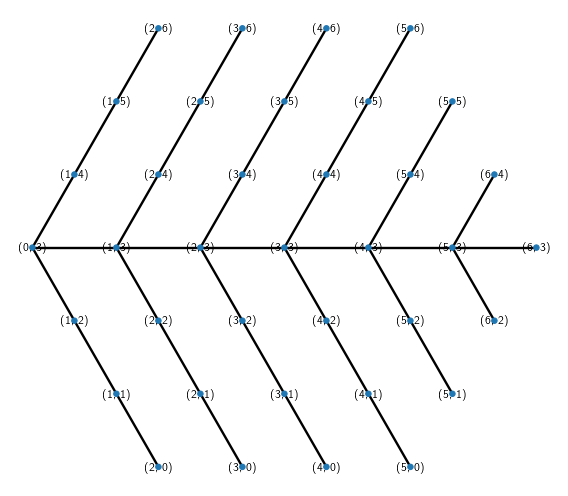

In [32]:
relaxation.plot_network(G)

In [33]:
for i in range(30): 
    relaxation.solve_P_theta(G)
    relaxation.new_k(G)
print('dissipation D:', G.graph['D'])
print('number of edges left:',G.number_of_edges())

dissipation D: 446878.59086869576
number of edges left: 36


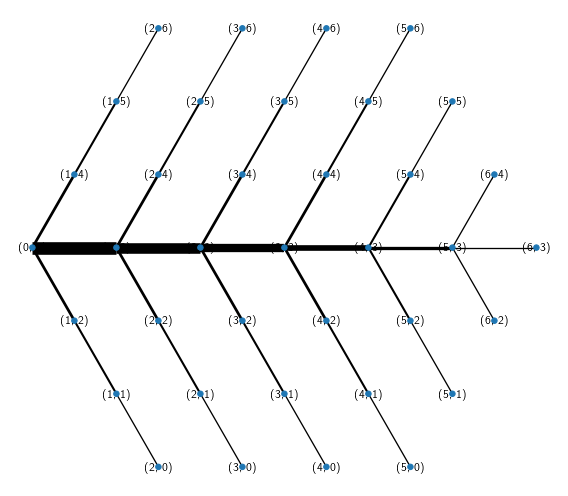

In [34]:
relaxation.plot_network(G)

Why are we not getting smaller dissipation from the beginning? - okay one shot learning the new k values I see.

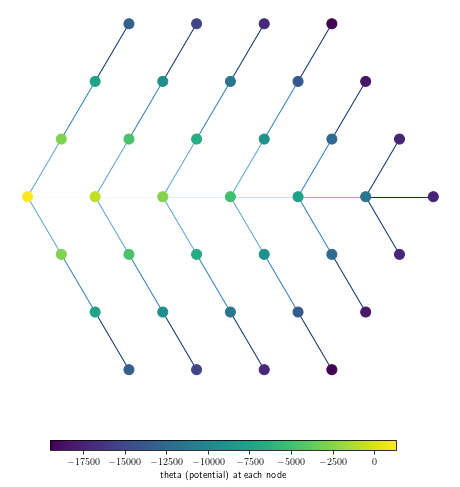

In [26]:
relaxation.plot_pressure(G)

In [83]:
G = parametrize_tree(N= 6,gamma = 0.5, hydathode = (2,1), strength = 5)

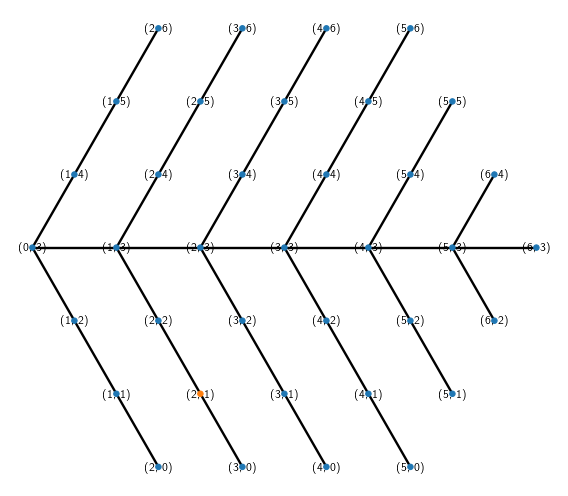

In [84]:
relaxation.plot_network(G)

In [85]:
for i in range(30): 
    relaxation.solve_P_theta(G)
    relaxation.new_k(G)
print('dissipation D:', G.graph['D'])
print('number of edges left:',G.number_of_edges())

dissipation D: 423920.7206164821
number of edges left: 36


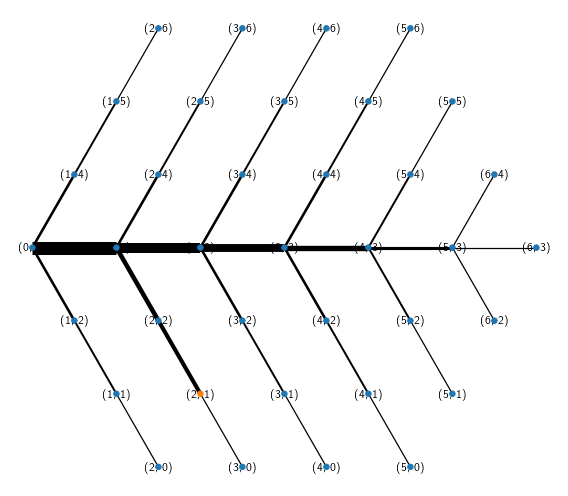

In [86]:
relaxation.plot_network(G)

- how to fix potential since when we solve it it's all about the differences... so is there are degree of freedom we can use?